# 与wavelet_lstm7模型ADHL对应

## 3层pyramid LSTM准确度对照实验 2021.4.29

In [1]:
#
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, utils, backend
import matplotlib.pyplot as plt

import xlrd
import time
import os

from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.compat.v1.keras.backend import set_session
tf.keras.backend.clear_session()  # For easy reset of notebook state.
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.9)
config_proto = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
sess = tf.compat.v1.Session(config=config_proto)
set_session(sess)

#输入数据
INPUT_SIZE = [288, 7]  #[time_steps, input_vector]
TIME_STEPS = INPUT_SIZE[0]
INPUT_NUM = INPUT_SIZE[1]
ENTIRE_INPUT_SIZE = [8, TIME_STEPS, 7]
ENTIRE_TIME_STEPS = ENTIRE_INPUT_SIZE[0] #总共时序长度

#局部编码器
LSTM1_INPUT_SIZE = 48 #局部时间长度
LSTM1_SIZE1 = 30
LSTM1_SIZE2 = 20
LSTM1_DENSE_SIZE = 20

#全局编码器
LSTM3_INPUT_SIZE = int(TIME_STEPS/LSTM1_INPUT_SIZE) #全局-局部时间长度，feature由上层定
LSTM3_INPUT_FEATURE = LSTM1_DENSE_SIZE
LSTM3_SIZE1 = 40
LSTM3_SIZE2 = 30
LSTM3_DENSE_SIZE = 30

#顶层时序决策器
LSTM5_INPUT_SIZE =  ENTIRE_INPUT_SIZE[0]
LSTM5_SIZE1 = 60
LSTM5_SIZE2 = 45
LSTM5_DENSE_SIZE = 45

#决策器
DENSE_SIZE = 600
OUTPUT_SIZE = 3

#训练信息
BATCH_SIZE = 64
PREDICTOR_TRAIN_BATCH1 = 15

TRAINDATA_LOADPATH = 'tool_wear_data_5/train_data.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = 'tool_wear_data_5/train_label.npy' #训练集标签读取路径
TESTDATA_LOADPATH = 'tool_wear_data_5/test_data.npy' #验证集数据读取路径
TESTLABEL_LOADPATH =  'tool_wear_data_5/test_label.npy' #验证集标签读取路径
SUMMARY_PATH = './logs'     #记录路径

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"# 这一行注释掉就是使用gpu

##############################数据集读取########################################
X_train=np.load(TRAINDATA_LOADPATH)
Y_train=np.load(TRAINLABEL_LOADPATH)
X_test=np.load(TESTDATA_LOADPATH)
Y_test=np.load(TESTLABEL_LOADPATH)

#validation_split将样本集按先后比例分为训练集合样本集，样本数量应为两者和的整数倍
X_train = X_train[:(np.shape(X_train)[0]-np.shape(X_train)[0]%BATCH_SIZE), :,:INPUT_NUM]
Y_train = Y_train[:(np.shape(Y_train)[0]-np.shape(Y_train)[0]%BATCH_SIZE), :OUTPUT_SIZE]
X_test = X_test[:(np.shape(X_test)[0]-np.shape(X_test)[0]%BATCH_SIZE), :,:INPUT_NUM]
Y_test = Y_test[:(np.shape(Y_test)[0]-np.shape(Y_test)[0]%BATCH_SIZE), :OUTPUT_SIZE]
X_train = np.reshape(X_train, [-1, ENTIRE_INPUT_SIZE[0], ENTIRE_INPUT_SIZE[1], ENTIRE_INPUT_SIZE[2]])
X_test = np.reshape(X_test, [-1, ENTIRE_INPUT_SIZE[0], ENTIRE_INPUT_SIZE[1], ENTIRE_INPUT_SIZE[2]])
print('X_train', np.shape(X_train))

###################局部编码器####################################
def adjust_range(x):#调整范围，将每一小段的信号都调整至-0.9~0.9
    max_val = backend.max(x, axis = 1, keepdims=True)#运算Tensor的第一维都是batch，在axis上取均值，为能够广播运算，必须keepdims
    min_val = backend.min(x, axis = 1, keepdims=True)
    y = (x - min_val)/(max_val - min_val + 1e-6)*1.8 - 0.9
    return y

# model各层之间必须用layers连接，如果不是layers必须重新用Input导入
input_img = layers.Input(shape=INPUT_SIZE, batch_size=BATCH_SIZE, name = 'input')#input_shape=[time_steps, input_vector]
x = layers.Lambda(adjust_range, name = 'adjust_range')(input_img)
x = layers.Reshape([LSTM3_INPUT_SIZE, LSTM1_INPUT_SIZE, INPUT_NUM])(x)
x = layers.TimeDistributed(layers.LSTM(LSTM1_SIZE1, return_sequences=True))(x)
local_state_h = layers.TimeDistributed(layers.LSTM(LSTM1_SIZE2, return_sequences=False))(x)
local_state_h = layers.TimeDistributed(layers.Dense(LSTM1_DENSE_SIZE, name = 'state_h'))(local_state_h)#[batch, LSTM3_INPUT_SIZE, LSTM1_DENSE_SIZE]
print('local_state_h', local_state_h)
local_encoder = models.Model(inputs=input_img, outputs=local_state_h, name='local_encoder_model')#局部LSTM编码器

###################全局编码器##################################
#全局编码器，输入局部编码器的local_state，输出global_state_h
def global_encoder_model_construct(name):
    global_encoder_input = layers.Input(shape=[LSTM3_INPUT_SIZE, LSTM3_INPUT_FEATURE], 
                                        batch_size = BATCH_SIZE, name='global_encoder_input')
    x = layers.LSTM(LSTM3_SIZE1, return_sequences=True, name='global_encoded_LSTM1')(global_encoder_input)
    global_state_h = layers.LSTM(LSTM3_SIZE2, return_sequences=False, name='global_encoded_LSTM2')(x)
    global_state_h = layers.Dense(LSTM3_DENSE_SIZE, name = 'global_state_h')(global_state_h)#[batch, LSTM3_INPUT_SIZE, LSTM1_DENSE_SIZE]
    print('global_state_h', global_state_h)
    global_encoder = models.Model(inputs=global_encoder_input, outputs=global_state_h, name = name)
    return global_encoder

global_encoder = global_encoder_model_construct('global_encoder_model')#全局LSTM编码器

#特征提取网络
global_state_h = global_encoder(local_state_h)
extract_network = models.Model(inputs=input_img, outputs=global_state_h, name='extract_network')

###################顶层编码器##################################
#顶层编码器，输入全局编码器的feature1~5，输出feature
def top_encoder_model_construct(name):
    top_encoder_input = layers.Input(shape=[LSTM5_INPUT_SIZE, LSTM3_DENSE_SIZE], 
                                        batch_size = BATCH_SIZE, name='top_encoder_input')
    x = layers.LSTM(LSTM5_SIZE1, return_sequences=True, name='top_encoded_LSTM1')(top_encoder_input)
    top_state_h  = layers.LSTM(LSTM5_SIZE2, return_sequences=False, name='top_encoded_LSTM2')(x)
    top_state_h = layers.Dense(LSTM5_DENSE_SIZE, name = 'top_state_h')(top_state_h)#[batch, LSTM5_INPUT_SIZE, LSTM1_DENSE_SIZE]
    top_encoder = models.Model(inputs=top_encoder_input, outputs=top_state_h, name = name)
    return top_encoder
top_encoder = top_encoder_model_construct('top_encoder_model')#全局LSTM编码器

###################顶层LSTM######################################
entire_input = layers.Input(shape=ENTIRE_INPUT_SIZE,  batch_size = BATCH_SIZE, name='entire_input')
top_input0 = layers.Lambda(lambda x:x[:, 0, :, :])(entire_input)
top_input1 = layers.Lambda(lambda x:x[:, 1, :, :])(entire_input)
top_input2 = layers.Lambda(lambda x:x[:, 2, :, :])(entire_input)
top_input3 = layers.Lambda(lambda x:x[:, 3, :, :])(entire_input)
top_input4 = layers.Lambda(lambda x:x[:, 4, :, :])(entire_input)
top_input5 = layers.Lambda(lambda x:x[:, 5, :, :])(entire_input)
top_input6 = layers.Lambda(lambda x:x[:, 6, :, :])(entire_input)
top_input7 = layers.Lambda(lambda x:x[:, 7, :, :])(entire_input)
feature0 = extract_network(top_input0)
feature1 = extract_network(top_input1)
feature2 = extract_network(top_input2)
feature3 = extract_network(top_input3)
feature4 = extract_network(top_input4)
feature5 = extract_network(top_input5)
feature6 = extract_network(top_input6)
feature7 = extract_network(top_input7)
feature0 = layers.Reshape([1, LSTM3_DENSE_SIZE])(feature0)
feature1 = layers.Reshape([1, LSTM3_DENSE_SIZE])(feature1)
feature2 = layers.Reshape([1, LSTM3_DENSE_SIZE])(feature2)
feature3 = layers.Reshape([1, LSTM3_DENSE_SIZE])(feature3)
feature4 = layers.Reshape([1, LSTM3_DENSE_SIZE])(feature4)
feature5 = layers.Reshape([1, LSTM3_DENSE_SIZE])(feature5)
feature6 = layers.Reshape([1, LSTM3_DENSE_SIZE])(feature6)
feature7 = layers.Reshape([1, LSTM3_DENSE_SIZE])(feature7)
feature = layers.Concatenate(axis = 1)([feature0, feature1, feature2, feature3, 
                                        feature4, feature5, feature6, feature7])#包含sample维度

###################决策器######################################
top_state_h = top_encoder(feature)
LSTM_encoder = models.Model(inputs=entire_input, outputs=top_state_h, name='LSTM_encoder')
x = layers.Dense(DENSE_SIZE, activation='tanh')(top_state_h)
dense_layer1 = models.Model(inputs=entire_input, outputs=x, name='dense_layer1')
x = layers.Dropout(0.5)(x)
output = layers.Dense(OUTPUT_SIZE, name='output', activation='tanh')(x)
predictor = models.Model(inputs=entire_input, outputs=output, name='predictor_model')
print('output', output)

#############################################模型训练#########################################################################
time_start = time.time()

adam = keras.optimizers.Adam(lr=0.0003)
predictor.compile(optimizer=adam, loss = 'mse')
history = predictor.fit(X_train, Y_train, epochs=PREDICTOR_TRAIN_BATCH1, batch_size=BATCH_SIZE, shuffle=True, verbose=1)

print('time1 =  ', time.time()-time_start)


X_train (29952, 8, 288, 7)
local_state_h KerasTensor(type_spec=TensorSpec(shape=(64, 6, 20), dtype=tf.float32, name=None), name='time_distributed_2/Reshape_1:0', description="created by layer 'time_distributed_2'")
global_state_h KerasTensor(type_spec=TensorSpec(shape=(64, 30), dtype=tf.float32, name=None), name='global_state_h/BiasAdd:0', description="created by layer 'global_state_h'")
output KerasTensor(type_spec=TensorSpec(shape=(64, 3), dtype=tf.float32, name=None), name='output/Tanh:0', description="created by layer 'output'")
Epoch 1/15
468/468 [==============================] - 103s 130ms/step - loss: 0.0568
Epoch 2/15
468/468 [==============================] - 61s 130ms/step - loss: 0.0063
Epoch 3/15
468/468 [==============================] - 61s 130ms/step - loss: 0.0045
Epoch 4/15
468/468 [==============================] - 59s 127ms/step - loss: 0.0037
Epoch 5/15
468/468 [==============================] - 59s 127ms/step - loss: 0.0032
Epoch 6/15
468/468 [====================

loss_train_avg 0.0017830740287497278
percent_train_avg 6.195271970808591 %
percent_train_avg[0] 7.074539835816479 %
percent_train_avg[1] 5.617920483588259 %
percent_train_avg[2] 5.893355593021032 %
loss_test_avg 0.0018018468986744298
percent_test_avg 6.188803350798808 %
percent_test_avg[0] 6.784069337862006 %
percent_test_avg[1] 5.6805681131407795 %
percent_test_avg[2] 6.101772601393636 %


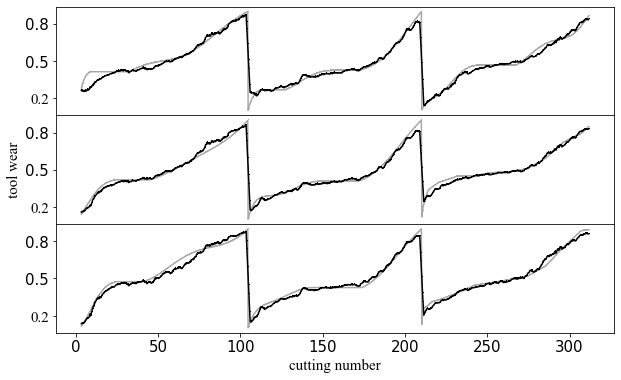

In [5]:
#
import numpy as np
import matplotlib.pyplot as plt
import pywt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    # 这一行注释掉就是使用gpu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, utils, backend
import time

from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.compat.v1.keras.backend import set_session
tf.keras.backend.clear_session()  # For easy reset of notebook state.
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.9)
config_proto = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off 
sess = tf.compat.v1.Session(config=config_proto)
set_session(sess)

TRAINDATA_LOADPATH = 'tool_wear_data_5_small/train_data.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH =  'tool_wear_data_5_small/train_label.npy' #训练集标签读取路径
TESTDATA_LOADPATH = 'tool_wear_data_5_small/test_data.npy' #验证集数据读取路径
TESTLABEL_LOADPATH =  'tool_wear_data_5_small/test_label.npy' #验证集标签读取路径


load_flag = 1 ########################################1:重新加载模型，0：不加载##########################
#输入数据
INPUT_SIZE = [2304, 7]  #[time_steps, input_vector]
INPUT_NUM = INPUT_SIZE[1]

SCALE_NUM_FORCE = 3 #小波分解级数
SCALE_NUM_VIBRATION = 3 #小波分解级数
SCALE_NUM_AE = 3 #小波分解级数
WAVELET_HIGHFREQ = 'db2'
WAVELET_LOWFREQ = 'db6'
# NOISE_FILTER_PERCENT = 90

ATTENTION_RANGE = 48
OUTPUT_SIZE = 3
BATCH_SIZE = 64
size = 15


################################################### 数据集读取及处理 ##################################################
X_train=np.load(TRAINDATA_LOADPATH)
Y_train=np.load(TRAINLABEL_LOADPATH)
X_test=np.load(TESTDATA_LOADPATH)
Y_test=np.load(TESTLABEL_LOADPATH)
X_train = X_train[:(np.shape(X_train)[0]-np.shape(X_train)[0]%BATCH_SIZE),:, :INPUT_NUM]
Y_train = Y_train[:(np.shape(Y_train)[0]-np.shape(Y_train)[0]%BATCH_SIZE), :OUTPUT_SIZE]
X_test = X_test[:(np.shape(X_test)[0]-np.shape(X_test)[0]%BATCH_SIZE),:, :INPUT_NUM]
Y_test = Y_test[:(np.shape(Y_test)[0]-np.shape(Y_test)[0]%BATCH_SIZE), :OUTPUT_SIZE]
X_train = np.reshape(X_train, [-1, ENTIRE_INPUT_SIZE[0], ENTIRE_INPUT_SIZE[1], ENTIRE_INPUT_SIZE[2]])
X_test = np.reshape(X_test, [-1, ENTIRE_INPUT_SIZE[0], ENTIRE_INPUT_SIZE[1], ENTIRE_INPUT_SIZE[2]])

################################################### 波形显示 ##################################################
fig_x = 10
fig_y = 6
plt.figure(figsize=(fig_x, fig_y))
plt.subplots_adjust(wspace=0, hspace=0)
font1 = {'family':'Times New Roman', 'weight':'normal', 'size':size}

#train
score = predictor.evaluate(X_train, Y_train, verbose=0, batch_size = BATCH_SIZE)
Y_pre_train = predictor.predict(X_train, batch_size = BATCH_SIZE)

v = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
result = [np.convolve(Y_pre_train[:, 0], v, mode='same'), np.convolve(Y_pre_train[:, 1], v, mode='same'), 
          np.convolve(Y_pre_train[:, 2], v, mode='same')]
result = np.transpose(result)

axis = np.linspace(1, 314, np.shape(result)[0])
print('loss_train_avg', np.mean(np.square(result - Y_train)))
print('percent_train_avg', np.mean(np.abs(result - Y_train)/Y_train)*100, '%')
print('percent_train_avg[0]', np.mean(np.abs(result[:, 0] - Y_train[:, 0])/Y_train[:, 0])*100, '%')
print('percent_train_avg[1]', np.mean(np.abs(result[:, 1] - Y_train[:, 1])/Y_train[:, 1])*100, '%')
print('percent_train_avg[2]', np.mean(np.abs(result[:, 2] - Y_train[:, 2])/Y_train[:, 2])*100, '%')

#test
score = predictor.evaluate(X_test, Y_test, verbose=0, batch_size = BATCH_SIZE)
Y_pre_test = predictor.predict(X_test, batch_size = BATCH_SIZE)

v = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
result = [np.convolve(Y_pre_test[:, 0], v, mode='same'), np.convolve(Y_pre_test[:, 1], v, mode='same'), 
          np.convolve(Y_pre_test[:, 2], v, mode='same')]
result = np.transpose(result)

axis = np.linspace(1, 314, np.shape(result)[0])
print('loss_test_avg', np.mean(np.square(result - Y_test)))
print('percent_test_avg', np.mean(np.abs(result - Y_test)/Y_test)*100, '%')
print('percent_test_avg[0]', np.mean(np.abs(result[:, 0] - Y_test[:, 0])/Y_test[:, 0])*100, '%')
print('percent_test_avg[1]', np.mean(np.abs(result[:, 1] - Y_test[:, 1])/Y_test[:, 1])*100, '%')
print('percent_test_avg[2]', np.mean(np.abs(result[:, 2] - Y_test[:, 2])/Y_test[:, 2])*100, '%')
        
for i in range(3):
    plt.subplot(3,1,i+1)
#     fig.xaxis.set_major_locator(ticker.MultipleLocator(3))
    if i == 0:
        plt.plot(axis[10:-10], Y_test[10:-10, i],'darkgrey',marker = ',',label = 'actual tool wear')
        plt.plot(axis[10:-10], result[10:-10, i],color = 'k', marker = ',', label = 'predicted result')
#         plt.legend(loc= 2, prop = font1)
        plt.xticks([])
    if i == 1:
        plt.plot(axis[10:-10], Y_test[10:-10, i],'darkgrey',marker = ',')
        plt.plot(axis[10:-10], result[10:-10, i],color = 'k', marker = ',')
        plt.xticks([])
        plt.ylabel('tool wear', fontproperties = 'Times New Roman', size = size)
    if i == 2:
        plt.plot(axis[10:-10], Y_test[10:-10, i],'darkgrey',marker = ',')
        plt.plot(axis[10:-10], result[10:-10, i],color = 'k', marker = ',')
        plt.xticks(fontproperties = 'Times New Roman', size = size)
#         plt.xlabel('cutting number', fontproperties = 'Times New Roman', size = 20)
    plt.yticks([0.2, 0.5, 0.8], fontproperties = 'Times New Roman', size = size)

    
plt.xlabel('cutting number', fontproperties = 'Times New Roman', size = size)
plt.savefig('test_output.png', dpi = 300)
plt.show()

## 经典双层LSTM+双层dense+dropout 准确度对照实验 2021.4.28

In [1]:

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, utils, backend
import matplotlib.pyplot as plt

import xlrd
import time
import os

#输入数据
INPUT_SIZE = [2304, 7]  #[time_steps, input_vector]
TIME_STEPS = INPUT_SIZE[0]
INPUT_NUM = INPUT_SIZE[1]
LSTM1_SIZE = 50
LSTM2_SIZE = 60
DENSE1_SIZE = 500
OUTPUT_SIZE = 3

#训练信息
BATCH_SIZE = 64
PREDICTOR_TRAIN_BATCH = 10

TRAINDATA_LOADPATH = 'tool_wear_data_5/train_data.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = 'tool_wear_data_5/train_label.npy' #训练集标签读取路径
TESTDATA_LOADPATH = 'tool_wear_data_5/test_data.npy' #验证集数据读取路径
TESTLABEL_LOADPATH =  'tool_wear_data_5/test_label.npy' #验证集标签读取路径
SUMMARY_PATH = './logs'     #记录路径

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"# 这一行注释掉就是使用gpu

##############################数据集读取########################################
X_train=np.load(TRAINDATA_LOADPATH)
Y_train=np.load(TRAINLABEL_LOADPATH)
X_test=np.load(TESTDATA_LOADPATH)
Y_test=np.load(TESTLABEL_LOADPATH)

#validation_split将样本集按先后比例分为训练集合样本集，样本数量应为两者和的整数倍
X_train = X_train[:(np.shape(X_train)[0]-np.shape(X_train)[0]%(BATCH_SIZE)), :, :INPUT_NUM]
print('X_train', np.shape(X_train))
Y_train = Y_train[:(np.shape(Y_train)[0]-np.shape(Y_train)[0]%(BATCH_SIZE)), :OUTPUT_SIZE]
print('Y_train', np.shape(Y_train))

X_test = X_test[:(np.shape(X_test)[0]-np.shape(X_test)[0]%(BATCH_SIZE)), :, :INPUT_NUM]
print('X_test', np.shape(X_test))
Y_test = Y_test[:(np.shape(Y_test)[0]-np.shape(Y_test)[0]%(BATCH_SIZE)), :OUTPUT_SIZE]
print('Y_test', np.shape(Y_test))

####################################模型搭建################################################################
def adjust_range(x):#调整范围，将每一小段的信号都调整至-0.9~0.9
    max_val = backend.max(x, axis = 1, keepdims=True)#运算Tensor的第一维都是batch，在axis上取均值，为能够广播运算，必须keepdims
    min_val = backend.min(x, axis = 1, keepdims=True)
    y = (x - min_val)/(max_val - min_val + 1e-6)*1.8 - 0.9
    return y

# model各层之间必须用layers连接，如果不是layers必须重新用Input导入
input_img = layers.Input(shape=INPUT_SIZE, batch_size=BATCH_SIZE, name = 'input')#input_shape=[time_steps, input_vector]
input_mask = layers.Masking(mask_value = 0)(input_img)
x = layers.Lambda(adjust_range, name = 'adjust_range')(input_mask)
x = layers.LSTM(LSTM1_SIZE, return_sequences=True, name = 'LSTM1')(x)
local_state_h = layers.LSTM(LSTM2_SIZE, return_sequences=False, name = 'LSTM2')(x)
dense1_output = layers.Dense(DENSE1_SIZE, name = 'dense1')(local_state_h)#(x)
dense1_output = layers.Dropout(0.5)(dense1_output)
output = layers.Dense(OUTPUT_SIZE, name = 'dense2')(dense1_output)

predictor = models.Model(inputs=[input_img], outputs=[output])

#############################################模型训练#########################################################################
time_start = time.time()

adam = keras.optimizers.Adam(lr=0.0005)
predictor.compile(optimizer=adam, loss = 'mse')
history = predictor.fit(X_train, Y_train, epochs=PREDICTOR_TRAIN_BATCH, batch_size=BATCH_SIZE, shuffle=True, verbose=1)

adam = keras.optimizers.Adam(lr=0.0001)
predictor.compile(optimizer=adam, loss = 'mse')
history = predictor.fit(X_train, Y_train, epochs=PREDICTOR_TRAIN_BATCH, batch_size=BATCH_SIZE, shuffle=True, verbose=1)

print('time1 =  ', time.time()-time_start)

X_train (29952, 2304, 7)
Y_train (29952, 3)
X_test (12800, 2304, 7)
Y_test (12800, 3)
Epoch 1/10
468/468 [==============================] - 1831s 4s/step - loss: 0.0494
Epoch 2/10
468/468 [==============================] - 1927s 4s/step - loss: 0.0084
Epoch 3/10
468/468 [==============================] - 1932s 4s/step - loss: 0.0067
Epoch 4/10
468/468 [==============================] - 1938s 4s/step - loss: 0.0055
Epoch 5/10
468/468 [==============================] - 1954s 4s/step - loss: 0.0049
Epoch 6/10
468/468 [==============================] - 1963s 4s/step - loss: 0.0044
Epoch 7/10
468/468 [==============================] - 1962s 4s/step - loss: 0.0037
Epoch 8/10
468/468 [==============================] - 1964s 4s/step - loss: 0.0036
Epoch 9/10
468/468 [==============================] - 1960s 4s/step - loss: 0.0031
Epoch 10/10
468/468 [==============================] - 1942s 4s/step - loss: 0.0032
Epoch 1/10
468/468 [==============================] - 1987s 4s/step - loss: 0.0024


(12800, 2304, 7)
(12800, 3)
loss 0.0020100658293813467


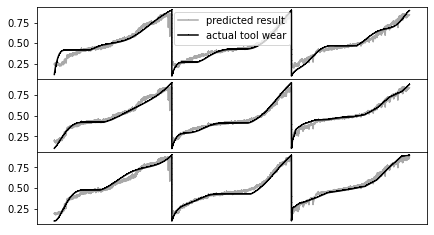

loss_test_avg 0.0013227566577733213
percent_test_avg 6.655852076083073 %
percent_test_avg[0] 8.411864513724876 %
percent_test_avg[1] 5.332651797495485 %
percent_test_avg[2] 6.223039917028858 %
loss 0.0020100658293813467


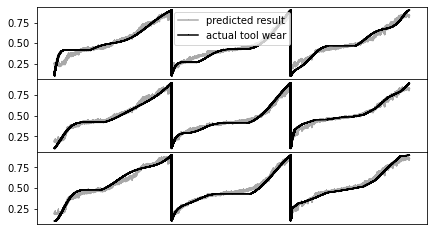

loss_train_avg 0.0016059080232545082
percent_train_avg 6.987665673548863 %


In [2]:
#
print(np.shape(X_test))
print(np.shape(Y_test))

score = predictor.evaluate(X_test, Y_test, verbose=0, batch_size=BATCH_SIZE)
Y_pre_test = predictor.predict(X_test, batch_size=BATCH_SIZE)
print(predictor.metrics_names[0], score)

v = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
result = [np.convolve(Y_pre_test[:, 0], v, mode='same'), np.convolve(Y_pre_test[:, 1], v, mode='same'), 
          np.convolve(Y_pre_test[:, 2], v, mode='same')]
result = np.transpose(result)

fig_x = 7
fig_y = 4
fig=plt.figure(figsize=(fig_x, fig_y))
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(3):
    plt.subplot(3,1,i+1)
    if i == 0:
        plt.plot(result[10:-10, i],color = 'darkgray', marker = ',', label = 'predicted result')
        plt.plot(Y_test[10:-10, i],'k',marker = ',',label = 'actual tool wear')
        plt.legend()
    else:
        plt.plot(result[10:-10, i],color = 'darkgray', marker = ',')
        plt.plot(Y_test[10:-10, i],'k',marker = ',')
    plt.xticks([])
plt.savefig('test_output.png', dpi = 300)
plt.show()

print('loss_test_avg', np.mean(np.square(result - Y_test)))
print('percent_test_avg', np.mean(np.abs(result - Y_test)/Y_test)*100, '%')
print('percent_test_avg[0]', np.mean(np.abs(result[:, 0] - Y_test[:, 0])/Y_test[:, 0])*100, '%')
print('percent_test_avg[1]', np.mean(np.abs(result[:, 1] - Y_test[:, 1])/Y_test[:, 1])*100, '%')
print('percent_test_avg[2]', np.mean(np.abs(result[:, 2] - Y_test[:, 2])/Y_test[:, 2])*100, '%')

#####################################################################################################################
    
Y_pre_train = predictor.predict(X_train, batch_size=BATCH_SIZE)
print(predictor.metrics_names[0], score)
    
v = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
result = [np.convolve(Y_pre_train[:, 0], v, mode='same'), np.convolve(Y_pre_train[:, 1], v, mode='same'), 
          np.convolve(Y_pre_train[:, 2], v, mode='same')]
result = np.transpose(result)

fig_x = 7
fig_y = 4
fig=plt.figure(figsize=(fig_x, fig_y))
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(3):
    plt.subplot(3,1,i+1)
    if i == 0:
        plt.plot(result[10:-10, i],color = 'darkgray', marker = ',', label = 'predicted result')
        plt.plot(Y_train[10:-10, i], 'k', marker = ',',label = 'actual tool wear')
        plt.legend()
    else:
        plt.plot(result[10:-10, i],color = 'darkgray', marker = ',')
        plt.plot(Y_train[10:-10, i], 'k', marker = ',')
    plt.xticks([])
plt.savefig('train_output.png', dpi = 300)
plt.show()

print('loss_train_avg', np.mean(np.square(result - Y_train)))
print('percent_train_avg', np.mean(np.abs(result - Y_train)/Y_train)*100, '%')